# Naive Bayes Classification of Large Movie Reviews Dataset

We will be implementing a Naive Bayes classifier on a Movie Reviews dataset. The classifier needs to predict the sentiment of the review being positive or negative.

We begin by importing all the necessary libraries.

In [1]:
import glob
import os
import random
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
nltk.download(['words', 'stopwords'], quiet=True)

base_path = 'data/aclImdb/'
subdirs = ['pos', 'neg']
COLUMNS = ['review', 'sentiment', 'p_pos', 'p_neg', 'predicted_sentiment']

## Load dataset

First thing's first, let us load the data into a DataFrame. In this case, the training and testing data are already separated. We shuffle the data to ensure that we don't end up biasing our model.

Also, we will pickle these dataframe to make consecutive runs faster.

In [3]:
def load_data(dir_type="train"):
    df = pd.DataFrame(columns=COLUMNS)
    for sub in subdirs:
        new_path = base_path + dir_type + "/" + sub + "/"
        for filename in glob.glob(new_path + "*.txt"):
            content = ''.join(open(filename, 'r').readlines())
            df = df.append(
                {"review": content, "sentiment": sub}, ignore_index=True)
    return df

train_data = pd.DataFrame(columns=COLUMNS)
test_data = pd.DataFrame(columns=COLUMNS)

train_data_changed = False
test_data_changed = False

train_pickle = "./train.pkl"
test_pickle = "./test.pkl"

if os.path.isfile(train_pickle) or train_data_changed:
    train_data = pd.read_pickle(train_pickle, compression="gzip")
else:
    train_data = load_data("train")
    print("Pickling training data")
    train_data.to_pickle(train_pickle, compression="gzip")

if os.path.isfile(test_pickle) or test_data_changed:
    test_data = pd.read_pickle(test_pickle, compression="gzip")
else:
    test_data = load_data("test")
    print("Pickling testing data")
    test_data.to_pickle(test_pickle, compression="gzip")

train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

print()
print("Training data:")
display(train_data)
print("Testing data:")
display(test_data)

Pickling training data
Pickling testing data

Training data:


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,I gave this film 10 not because it is a superb...,pos,NaN,NaN,NaN
1,"For a low budget project, the Film was a succe...",pos,NaN,NaN,NaN
2,"I recently watched the first Guinea Pig film, ...",neg,NaN,NaN,NaN
3,The movie itself is so pathetic. It portrayed ...,neg,NaN,NaN,NaN
4,"The Second Renaissance, part 1 let's us show h...",neg,NaN,NaN,NaN
...,...,...,...,...,...
24995,A brilliant chess player attends a tournament ...,pos,NaN,NaN,NaN
24996,"The first time I saw this, I didn't laugh too ...",pos,NaN,NaN,NaN
24997,"Highly enjoyable, very imaginative, and filmic...",pos,NaN,NaN,NaN
24998,"After Life is a Miracle, I did not expect much...",neg,NaN,NaN,NaN


Testing data:


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,The movie was awful. The production company sh...,neg,NaN,NaN,NaN
1,"eXistenZ was a good film, at the first I was w...",pos,NaN,NaN,NaN
2,"As it turns out, Chris Farley and David Spade ...",pos,NaN,NaN,NaN
3,The bipolarity of this movie is maddening. One...,neg,NaN,NaN,NaN
4,This is more than just an adaptation of Bond: ...,neg,NaN,NaN,NaN
...,...,...,...,...,...
24995,"This is,in short,the TV comedy series with the...",pos,NaN,NaN,NaN
24996,I thought this movie was quite good. It was on...,pos,NaN,NaN,NaN
24997,"Lucio Fulci, a director not exactly renowned f...",neg,NaN,NaN,NaN
24998,When I first saw this I thought bits of it wer...,neg,NaN,NaN,NaN


We will then see if the data is balanced i.e. we have an equal distribution of datapoints for all the classes. This also prevents our model from developing a bias during training.

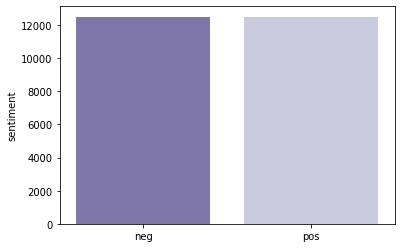

In [4]:
sns.barplot(train_data['sentiment'].value_counts().index,
            train_data['sentiment'].value_counts(), palette='Purples_r')
plt.show()

## Data Cleaning

This dataset in particular is perfectly balanced, as all things should be. Now, since we have all the data loaded, we need to clean it.

There are numerous methods that we can use to clean data and here we will implement some of them. Most of the cleaning depends on the dataset at hand so make sure you explore the dataset before you begin cleaning.

To start off, we will do the following:
- Ensure all text is in lowercase
- Remove unncessary whitespaces
- Remove HTML tags
- Remove URLs
- Remove punctuation
- Remove other types of spaces such as newlines and tab spaces
- Remove words that have numbers between them (usually usernames)

In [5]:
def clean_text(text):
    text = text.lower().strip()
    text = " ".join([w for w in text.split() if len(w) > 2])
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train_data['review'] = train_data['review'].apply(clean_text)
test_data['review'] = test_data['review'].apply(clean_text)

print("Cleaned data:")
display(train_data.head())
display(test_data.head())

Cleaned data:


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,gave this film not because superbly consistent...,pos,NaN,NaN,NaN
1,for low budget project the film was success th...,pos,NaN,NaN,NaN
2,recently watched the first guinea pig film the...,neg,NaN,NaN,NaN
3,the movie itself pathetic portrayed deaf peopl...,neg,NaN,NaN,NaN
4,the second renaissance part lets show how the ...,neg,NaN,NaN,NaN


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,the movie was awful the production company sho...,neg,NaN,NaN,NaN
1,existenz was good film the first was wondering...,pos,NaN,NaN,NaN
2,turns out chris farley and david spade only ma...,pos,NaN,NaN,NaN
3,the bipolarity this movie maddening one moment...,neg,NaN,NaN,NaN
4,this more than just adaptation bond its plain ...,neg,NaN,NaN,NaN


## Data exploration using WordCloud

Now that we've performed some basic cleaning, which is generally the same for most texual datasets, we need to perform some dataset specific cleaning now.

Most textual data in datasets is often considered "noise" as they are beneficial for humans and help them understand context. But, since computers can't do that, not to the extent we'd like, at least, we are better off removing this noise.

This often helps us clearly see relationships and trends in the dataset and reduces unnecessary computation.

Before we do that, let's see what kinds of words are dominating each of the datasets. To do that, we generate a WordCloud for both the Positive and the Negative Reviews.

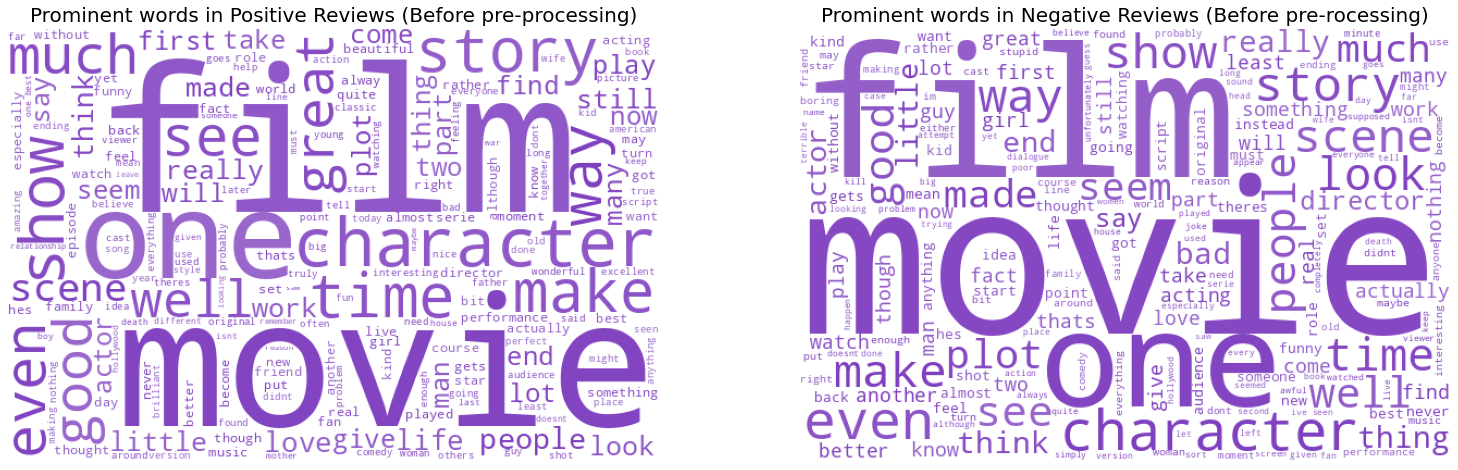

In [6]:
def purple_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(270, 50%%, %d%%)" % random.randint(50, 60)


pos_reviews = train_data[train_data['sentiment']
                                == "pos"]['review'].copy(deep=True)
neg_reviews = train_data[train_data['sentiment']
                                == "neg"]['review'].copy(deep=True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(pos_reviews))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Prominent words in Positive Reviews (Before pre-processing)', fontsize=20)

wordcloud2 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(neg_reviews))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Prominent words in Negative Reviews (Before pre-rocessing)', fontsize=20)
plt.show()

## Tokenization of Reviews

We see that the words like film, movie, one, character, show, etc. are dominating the reviews. Most of these words don't contribute to the sentiment but are present in the review for structre.

We can also see that there are several other words such as stopwords that don't really contribute much to the reviews as well.

We will remove all these words to reduce the noise and surface the important words that contribute to the sentiment of the review.

Before we do that, we need to tokenize the data. Each review is split into a list of words which we can easily work on.

In [7]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train_data['review'] = train_data['review'].apply(tokenizer.tokenize)
test_data['review'] = test_data['review'].apply(tokenizer.tokenize)

print("Tokenized reviews:")
display(train_data.head())
display(test_data.head())

Tokenized reviews:


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,"[gave, this, film, not, because, superbly, con...",pos,NaN,NaN,NaN
1,"[for, low, budget, project, the, film, was, su...",pos,NaN,NaN,NaN
2,"[recently, watched, the, first, guinea, pig, f...",neg,NaN,NaN,NaN
3,"[the, movie, itself, pathetic, portrayed, deaf...",neg,NaN,NaN,NaN
4,"[the, second, renaissance, part, lets, show, h...",neg,NaN,NaN,NaN


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,"[the, movie, was, awful, the, production, comp...",neg,NaN,NaN,NaN
1,"[existenz, was, good, film, the, first, was, w...",pos,NaN,NaN,NaN
2,"[turns, out, chris, farley, and, david, spade,...",pos,NaN,NaN,NaN
3,"[the, bipolarity, this, movie, maddening, one,...",neg,NaN,NaN,NaN
4,"[this, more, than, just, adaptation, bond, its...",neg,NaN,NaN,NaN


## Stopwords Removal

Now that the data is tokenized, we can remove the stopwords.

I've also included a list of other words that I feel don't contribute to the positive or negative sentiment based on the WordCloud we just generated.

In [8]:
def remove_stopwords(text):
    words = [
        w for w in text if w not in stop_words and w in words_corpus or not w.isalpha()]
    words = list(filter(lambda word: words.count(word) >= 2, set(words)))
    return words


words_corpus = set(nltk.corpus.words.words())
stop_words = set(stopwords.words('english'))

remove = ['movie', 'film', 'one', 'made', 'many', 'time', 'story', 'character', 'still', 'seen', 'picture', 'people', 'see', 'never', 'come',
          'even', 'way', 'plot', 'house', 'horror', 'think', 'make', 'first', 'scene', 'director', 'two', 'show', 'become', 'brother', 'che', 'got', 'ago']
stop_words = stop_words.union(remove)

print("Removing {} stopwords from text".format(len(stop_words)))
print()

train_data['review'] = train_data['review'].apply(remove_stopwords)
test_data['review'] = test_data['review'].apply(remove_stopwords)

print("After removing stopwords:")
display(train_data.head())
display(test_data.head())

Removing 211 stopwords from text

After removing stopwords:


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,[],pos,NaN,NaN,NaN
1,"[could, project, low, budget]",pos,NaN,NaN,NaN
2,"[truth, guinea, look, away, pig, might, didnt,...",neg,NaN,NaN,NaN
3,"[like, boring, hearing, deaf, pathetic]",neg,NaN,NaN,NaN
4,"[right, violent, silly, renaissance, second, p...",neg,NaN,NaN,NaN


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,"[electricity, send, would]",neg,NaN,NaN,NaN
1,"[going, good]",pos,NaN,NaN,NaN
2,"[company, truly, auto, tommy, spade, big]",pos,NaN,NaN,NaN
3,"[hero, star, revolutionary, basically, point]",neg,NaN,NaN,NaN
4,[],neg,NaN,NaN,NaN


## Lemmatization

Next, we lemmatize the data to ensure that reviews don't contain different forms of the same word.

This helps us reduce unnecessary computation.

In [9]:
def lemmatize_data(text):
    return [lemmatizer.lemmatize(w) for w in text]


lemmatizer = nltk.stem.WordNetLemmatizer()

train_data['review'] = train_data['review'].apply(lemmatize_data)
test_data['review'] = test_data['review'].apply(lemmatize_data)

display(train_data.head())
display(test_data.head())

,review,sentiment,p_pos,p_neg,predicted_sentiment
0,[],pos,NaN,NaN,NaN
1,"[could, project, low, budget]",pos,NaN,NaN,NaN
2,"[truth, guinea, look, away, pig, might, didnt,...",neg,NaN,NaN,NaN
3,"[like, boring, hearing, deaf, pathetic]",neg,NaN,NaN,NaN
4,"[right, violent, silly, renaissance, second, p...",neg,NaN,NaN,NaN


,review,sentiment,p_pos,p_neg,predicted_sentiment
0,"[electricity, send, would]",neg,NaN,NaN,NaN
1,"[going, good]",pos,NaN,NaN,NaN
2,"[company, truly, auto, tommy, spade, big]",pos,NaN,NaN,NaN
3,"[hero, star, revolutionary, basically, point]",neg,NaN,NaN,NaN
4,[],neg,NaN,NaN,NaN


## Removing rarely occuring words

In order to further reduce computation, we will remove rarely occuring words. Since their occurence is rare, their contribution to the overall sentiment is miniscule.

Due to this, we will remove words that occur less than 5 times in the overall dataset.

In [10]:
def remove_rare_words(text, rare_words):
    removed_rare_words = list(set(text) - set(rare_words))
    return removed_rare_words


def find_remove_rare_words(dataframe):
    exploded = dataframe.explode('review')
    word_counts = exploded.review.value_counts(ascending=True)
    rare_words = word_counts[word_counts <= 5].index.to_list()

    dataframe['review'] = dataframe['review'].apply(
        lambda x: remove_rare_words(x, rare_words))

    print("Before:", exploded.shape[0], "\nAfter:", dataframe.explode(
        'review').shape[0])
    return dataframe


print("Removing rare words for training data")
train_data = find_remove_rare_words(train_data)
print()

print("Removing rare words for test data")
test_data = find_remove_rare_words(test_data)

Removing rare words for training data
Before: 196213 
After: 184125

Removing rare words for test data
Before: 191739 
After: 179867


## Prominent words in reviews after pre-processing

That's pretty much all the cleaning we are going to do on this dataset. Let's join back all the words in the reviews and have a quick glance at the final WordCloud.

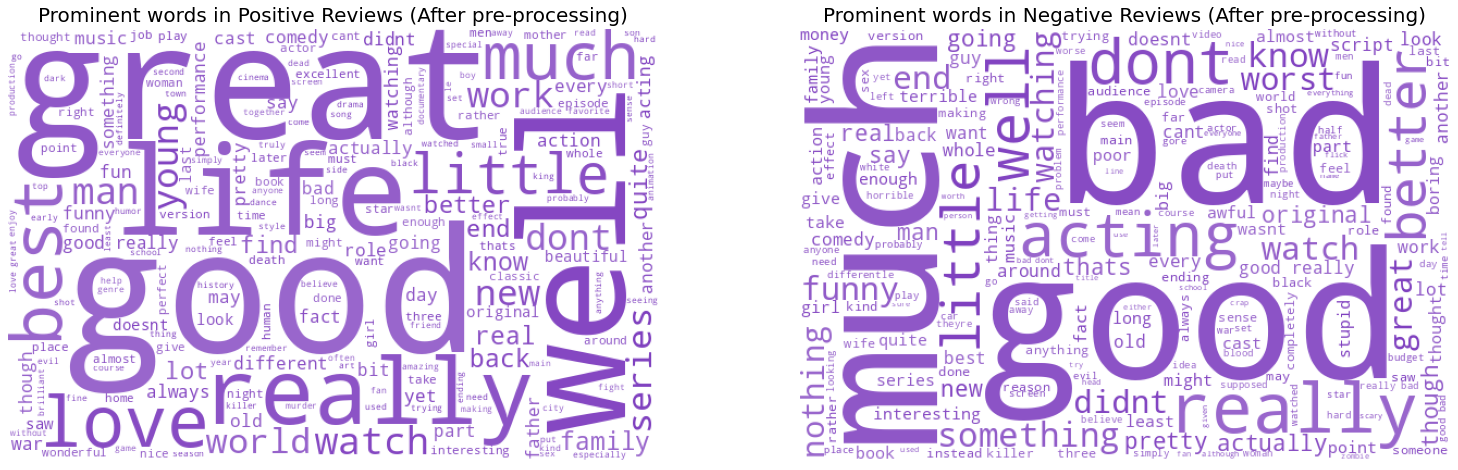

In [11]:
def combine_text(list_of_text):
    combined_text = ' '.join(token for token in list_of_text)
    return combined_text


pos_reviews = train_data[train_data['sentiment']
                                == "pos"]['review'].copy(deep=True).apply(combine_text)
neg_reviews = train_data[train_data['sentiment']
                                == "neg"]['review'].copy(deep=True).apply(combine_text)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(pos_reviews))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Prominent words in Positive Reviews (After pre-processing)', fontsize=20)

wordcloud2 = WordCloud(background_color='white',
                       color_func=purple_color_func,
                       random_state=3,
                       width=600,
                       height=400).generate(" ".join(neg_reviews))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Prominent words in Negative Reviews (After pre-processing)', fontsize=20)
plt.show()

We can see that a lot of the noise has been cleared now. Most of the important words that contribute to the positive or negative sentiments are dominating which was our goal.

Also, after cleaning, there might be reviews that have no words remaining in them mainly due to them not contributing much. It's best to just drop these rows and reduce unnecessary computation.

In [12]:
def drop_empty_reviews(df):
    df = df.drop(df[~df.review.astype(bool)].index)
    return df


train_data = drop_empty_reviews(train_data)
test_data = drop_empty_reviews(test_data)

## Splitting training data

Now, we split the training dataset to train and dev. We will be using the dev data for testing until we decide on optimal hyperparameters to use. This helps reduce bias as the test data remains untouched.

In [13]:
rows = 10000
split = 0.8

mid = int(np.floor_divide(rows, 1/split))

sample_train_data = train_data[:mid].copy(deep=True)
sample_dev_data = train_data[mid:mid + (rows - mid)].copy(deep=True)
sample_test_data = test_data[:rows].copy(deep=True)

print("No. of reviews in training dataset:", sample_train_data.shape[0])
print("No. of reviews in dev dataset:", sample_dev_data.shape[0])
print("No. of reviews in test dataset:", sample_test_data.shape[0])

No. of reviews in training dataset: 8000
No. of reviews in dev dataset: 2000
No. of reviews in test dataset: 10000


## Implementing Naive Bayes

Since the data is ready, we now move to the main part. We will use a Naive Bayes classifier to predict the sentiment of each review.

Since we will be using the dev data, we already have the correct sentiment in the dataset which we will use to calculate the accuracy of our predictions.

The Naive Bayes classifier uses a modified version of Bayes Theorem to achieve this.

In [14]:
# p_w_sent = # of time w occurs in df[sent] / # of docs in df[sent] -> likelihood
# p_sent = # of docs in df[sent] / # of total docs -> class prior prob

# pos_prob = p_sent_pos * (p_w1_sent_pos * p_w2_sent_pos * ...)
# neg_prob = p_sent_neg * (p_w1_sent_neg * p_w2_sent_neg * ...)

# p_sent_w = max(pos_prob,neg_prob) -> posterior prob

def populate_word_probabilities_dict(train):
    word_counts = {}
    
    docs_w_pos_sent = train[train.sentiment == "pos"]
    no_of_docs_w_pos_sent = docs_w_pos_sent.shape[0]

    docs_w_neg_sent = train[train.sentiment == "neg"]
    no_of_docs_w_neg_sent = docs_w_neg_sent.shape[0]

    for row in train.itertuples():
        review = row.review

        for word in review:
            p_word_w_pos_sent = None
            p_word_w_neg_sent = None

            if word in word_counts.keys():
                p_word_w_pos_sent = word_counts[word]['p_pos']
                p_word_w_neg_sent = word_counts[word]['p_neg']
            else:
                no_of_docs_w_word_pos_sent = docs_w_pos_sent[docs_w_pos_sent.review.apply(lambda x: bool(set(x) & {word}))].shape[0]
                no_of_docs_w_word_neg_sent = docs_w_neg_sent[docs_w_neg_sent.review.apply(lambda x: bool(set(x) & {word}))].shape[0]
                
                p_word_w_pos_sent = round(no_of_docs_w_word_pos_sent / no_of_docs_w_pos_sent, 4)
                p_word_w_neg_sent = round(no_of_docs_w_word_neg_sent / no_of_docs_w_neg_sent, 4)
                
                word_counts[word] = {'p_pos': p_word_w_pos_sent, 'p_neg': p_word_w_neg_sent}
    return word_counts

def nb_predict(train, test, smoothing=False):
    print("Processing")
    
    train_word_probs = populate_word_probabilities_dict(train)

    correct = 0
    smoothing_param = 0

    if smoothing:
        smoothing_param = 1 / \
            sample_train_data.explode('review').review.shape[0]

    for row in test.itertuples():
        review = row.review
        pos_prob = 1.0
        neg_prob = 1.0

        for word in review:
            p_word_w_pos_sent = 0.0
            p_word_w_neg_sent = 0.0
            
            if word in train_word_probs.keys():
                probs_word = train_word_probs[word]
                p_word_w_pos_sent = probs_word['p_pos']
                p_word_w_neg_sent = probs_word['p_neg']
            
            pos_prob = pos_prob * (p_word_w_pos_sent + smoothing_param)
            neg_prob = neg_prob * (p_word_w_neg_sent + smoothing_param)

        total_train_docs = train.shape[0]
    
        no_of_docs_w_pos_sent = train[train.sentiment == "pos"].shape[0]
        no_of_docs_w_neg_sent = train[train.sentiment == "neg"].shape[0]
        
        p_pos_sent = round(no_of_docs_w_pos_sent / total_train_docs, 4)
        p_neg_sent = round(no_of_docs_w_neg_sent / total_train_docs, 4)
        
        pos_prob = p_pos_sent * pos_prob
        neg_prob = p_neg_sent * neg_prob

        predicted_sent = 0

        if pos_prob > neg_prob:
            predicted_sent = "pos"
        elif pos_prob < neg_prob:
            predicted_sent = "neg"

        if row.sentiment == predicted_sent:
            correct += 1

        test.at[row.Index, 'p_pos'] = pos_prob
        test.at[row.Index, 'p_neg'] = neg_prob
        test.at[row.Index, 'predicted_sentiment'] = predicted_sent

    accuracy = round(correct / test.shape[0] * 100, 2)
    print("Accuracy: {}%".format(accuracy))
    return

print("Predicting setiment of review using Naive Bayes Classifer")
print()
nb_predict(sample_train_data, sample_dev_data)

display(sample_dev_data.head(10))

Predicting setiment of review using Naive Bayes Classifer

Processing
Accuracy: 65.7%


,review,sentiment,p_pos,p_neg,predicted_sentiment
8621,"[police, final, like, hong, dog, emotional, qu...",pos,0,0,0
8622,"[script, watching]",pos,7.71513e-05,0.000357276,neg
8623,"[like, ship, mood, young, dog, three, life, bo...",pos,0,1.50634e-49,neg
8624,"[fun, lot, there]",pos,4.38243e-06,3.91419e-06,pos
8625,"[like, go, much, serial, couple, young, doesnt...",pos,7.4e-27,2.98703e-27,pos
8626,"[peter, like, classic, dunne, bunch, fake]",pos,2.84404e-16,5.16792e-15,neg
8627,"[primary, mention, love, boring, without, woul...",neg,0,3.3792e-16,neg
8628,"[asylum, like, dean, didnt, power, episode, wh...",neg,0,5.30595e-47,neg
8629,"[tunnel, office, didnt, take, space, doubt, pr...",neg,6.1085e-17,2.25036e-17,pos
8630,"[wonderful, music, terrible]",pos,1.36208e-07,1.06704e-07,pos


## Cross-validation

Let's just ensure that this accuracy is consistent across multiple passes. To to this, we will implement a 5 fold cross validation where we split the training dataset into 5 chunks, use one of them for testing and the remaining for training.

To ensure consistency, we will use a different chunk every time we test.

In [15]:
def cross_validation(train, k, smoothing=False):
    dev = 1/k

    for i in range(1, k + 1):
        dev_chunk = train.sample(
            frac=dev, replace=False, random_state=i).copy(deep=True)
        train_chunk = train.drop(dev_chunk.index, axis=0).copy(deep=True)

        if smoothing:
            print("Cross-validation Pass", i, "with smoothing")
        else:
            print("Cross-validation Pass", i)

        nb_predict(train_chunk, dev_chunk, smoothing)

        print()
    return


cross_validation(sample_train_data, 5)

Cross-validation Pass 1
Processing
Accuracy: 64.19%

Cross-validation Pass 2
Processing
Accuracy: 63.12%

Cross-validation Pass 3
Processing
Accuracy: 62.38%

Cross-validation Pass 4
Processing
Accuracy: 62.19%

Cross-validation Pass 5
Processing
Accuracy: 64.62%



## Smoothing

While this accuracy isn't bad, I'm sure we can try to make it better. As you can see, there are a few reviews that have been classified incorrectly and some of them are classified as "0". 

This is the zero-frequency problem. This happens when a word that is not observed in training appears from the test dataset.

This issue will always crop up irrespective of how clean the dataset is.

Mainly due to the fact that we haven't calculated the probabilities of every word in the English language. We have just calculated for the ones in the training set.

To mitigate this issue, we can implement something called "Smoothing". Using this, even when a new word is introduced into the dataset, the sentiment of the document doesn't become zero.

We will be using something called "Laplace Smoothing" or "Add-one smoothing"

In [16]:
print("Predicting setiment of review using Naive Bayes Classifer with smoothing")
print()

nb_predict(sample_train_data, sample_dev_data, smoothing=True)

Predicting setiment of review using Naive Bayes Classifer with smoothing

Processing
Accuracy: 71.0%


## Cross-validation with smoothing

As we can see, the accuracy got better with smoothing. It's not by a lot but the difference is tangible.

We will verify the consistency of these results using Cross Validation with smoothing enabled.

In [17]:
cross_validation(sample_train_data, 5, smoothing=True)

Cross-validation Pass 1 with smoothing
Processing
Accuracy: 69.94%

Cross-validation Pass 2 with smoothing
Processing
Accuracy: 70.88%

Cross-validation Pass 3 with smoothing
Processing
Accuracy: 69.31%

Cross-validation Pass 4 with smoothing
Processing
Accuracy: 69.12%

Cross-validation Pass 5 with smoothing
Processing
Accuracy: 71.75%



## Top 10 prominent words

Here, we explore which are the top 10 most prominent words that lead to a positive or a negative prediction

In [18]:
accurate_predictions = sample_dev_data[(sample_dev_data.sentiment == sample_dev_data.predicted_sentiment) & (sample_dev_data.review.str.len() == 1)]

pos_preds = accurate_predictions[accurate_predictions.sentiment == "pos"].sort_values(by=['p_pos'], ascending=False)
top_ten_pos = pos_preds.explode('review').review.unique()[:10].tolist()

print("Top 10 words that predicts a positive review:")
for i, word in enumerate(top_ten_pos):
    print("{}. {}".format(i + 1, word))
print()

neg_preds = accurate_predictions[accurate_predictions.sentiment == "neg"].sort_values(by=['p_neg'], ascending=False)
top_ten_neg = neg_preds.explode('review').review.unique()[:10].tolist()

print("Top 10 words that predicts a negative review:")
for i, word in enumerate(top_ten_neg):
    print("{}. {}".format(i + 1, word))

Top 10 words that predicts a positive review:
1. good
2. great
3. love
4. best
5. little
6. back
7. real
8. though
9. family
10. role

Top 10 words that predicts a negative review:
1. like
2. bad
3. would
4. get
5. dont
6. much
7. could
8. watch
9. acting
10. know


## Final output on Test data with smoothing enabled

Now, it is clear that the classifier is performing well with smoothing enabled, thus, we will enable smoothing and calculate the final accuracy on the untouched test data. This should be our final answer.

The final accuracy is generally expected to be lower than the training accuracy mainly due to the removal of the biases we may have developed while training our model.

In [ ]:
nb_predict(train_data, test_data, smoothing=True)

Processing


## References:

[Large Movie Reviews Dataset - Stanford AI](https://ai.stanford.edu/~amaas/data/sentiment/)

[Probability Smoothing - Lazy Programmer](https://lazyprogrammer.me/probability-smoothing-for-natural-language-processing/)

[Laplace Smoothing - Monkey Learn](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/)

[K-fold cross-validation - Machine Learning Mastery](https://machinelearningmastery.com/k-fold-cross-validation/)